# Market Microstructure

By Beha Abasi, Jonathan Larkin, Maxwell Margenot, and Delaney Granizo-Mackenzie

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

Market microstructure is the broad study of the functions and operations of financial markets. This field includes research on how exchanges and trading venues are created and how they facilitate the transfer of financial assets between buyers and sellers. It also looks at the tension between the conflicting interests of opposing parties and how this affects price discovery. Furthermore, quotes, spreads, and transaction costs are important pillars of this field. Due to the proliferation of algorithmic trading, market microstructure has turned into one of the fastest growing domains of microeconomic research.

Although much of economic theory suggests that markets are frictionless, that is never the case and it is this same friction that often leads to costly implementation of investment strategies and alpha deterioration. A common reason why investment ideas conceived in research sometimes fail to pan out in the actual execution is because crucial market considerations were not accounted for, leading to the improper trading of alpha generating strategies.

As briefly discussed in the [Volume, Slippage, and Liquidity](https://www.quantopian.com/lectures/introduction-to-volume-slippage-and-liquidity) lecture, a good starting point in microstructure would be to look at intraday profiles. We will consider the intraday movements of volume and volatility, compare across different classes of assets and discuss why these considerations may be the determinants of whether a strategy is profitable or not.

Let's start by making some imports.

In [1]:
import pandas as pd
import numpy as np
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import Returns, Latest
from quantopian.pipeline.filters.morningstar import Q1500US, Q500US
from quantopian.research import run_pipeline
import matplotlib.pyplot as plt
from quantopian.pipeline.data.builtin import USEquityPricing
import time
import scipy.stats as stats

We'll gather some of the data we will use in this section and later parts of the lecture, and define our asset groups.

In [4]:
def make_pipeline():
    
    # define our fundamental factor pipeline
    pipe = Pipeline()
    
    # get daily volume data
    volume = Latest([USEquityPricing.volume])
    pipe.add(volume, 'volume')
    
    # get daily returns
    returns = Returns(window_length=2)
    pipe.add(returns, 'returns')
    
    # get shares outstanding
    shares_outstanding = Latest([morningstar.valuation.shares_outstanding])
    pipe.add(shares_outstanding, 'shares_outstanding')
    
    # get market cap
    market_cap = Latest([morningstar.valuation.market_cap])
    pipe.add(market_cap, 'market_cap')
    
    market_cap_rank = market_cap.rank()
    biggest = market_cap_rank.top(1000)
    pipe.add(biggest, 'large_cap')
    smallest = market_cap_rank.bottom(1000)
    pipe.add(smallest, 'small_cap')
    
    # in Q1500US
    q1500_universe = Q1500US()
    pipe.add(q1500_universe, 'Q1500')
    
    # in Q500US
    q500_universe = Q500US()
    pipe.add(q500_universe, 'Q500')
    
    return pipe

# Initializing the pipe
pipe = make_pipeline()

# Dependency Graph
pipe.show_graph('png')

# Now let's start the pipeline
start_date, end_date = '2016-12-01', '2016-12-31' 

pipeline_results = run_pipeline(pipe, start_date, end_date)
pipeline_results.dropna(inplace=True)
pipeline_results.head()

Q1500   Q500 large_cap  \
2016-12-01 00:00:00+00:00 Equity(21 [AAME])  False  False     False   
                          Equity(24 [AAPL])   True   True      True   
                          Equity(31 [ABAX])  False  False     False   
                          Equity(39 [DDC])   False  False     False   
                          Equity(41 [ARCB])  False  False     False   

                                               market_cap   returns  \
2016-12-01 00:00:00+00:00 Equity(21 [AAME])  7.655710e+07  0.066667   
                          Equity(24 [AAPL])  5.943400e+11 -0.008434   
                          Equity(31 [ABAX])  1.176550e+09 -0.012450   
                          Equity(39 [DDC])   8.307590e+08  0.010048   
                          Equity(41 [ARCB])  7.763620e+08  0.006601   

                                             shares_outstanding small_cap  \
2016-12-01 00:00:00+00:00 Equity(21 [AAME])        2.047530e+07      True   
                          Equity(24 [AAPL])        5.332310e+09     False   
                          Equity(31 [ABAX])        2.253300e+07     False   
                          Equity(39 [DDC])         8.781810e+07     False   
                          Equity(41 [ARCB])        2.574970e+07     False   

                                                 volume  
2016-12-01 00:00:00+00:00 Equity(21 [AAME])       469.0  
                          Equity(24 [AAPL])  25115705.0  
                          Equity(31 [ABAX])    163531.0  
                          Equity(39 [DDC])     221162.0  
                          Equity(41 [ARCB])    257181.0

In [5]:
large_cap_assets = pipeline_results[pipeline_results.large_cap].xs('2016-12-1').index.values
small_cap_assets = pipeline_results[pipeline_results.small_cap].xs('2016-12-1').index.values
Q500_assets = pipeline_results[pipeline_results.Q500].xs('2016-12-1').index.values
Q1500_assets = pipeline_results[pipeline_results.Q1500].xs('2016-12-1').index.values
other_assets = pipeline_results[~(pipeline_results.Q1500) & ~(pipeline_results.Q500)].xs('2016-12-1').index.values

# Intraday Profiles of Volume/Volatility

Since we want to look at intraday movements, we'll need to use the get_pricing method instead of pipeline for minutely data. Volume is a standard field on the Quantopian platform, so we can call it directly without the need for any other calculations.

In [6]:
all_large_cap_data = get_pricing(large_cap_assets, frequency='minute',start_date='2016-12-1', end_date='2016-12-31')
large_cap_volume = all_large_cap_data['volume']
large_cap_volume = large_cap_volume.tz_convert('US/Eastern') # Q data comes in as UTC

all_small_cap_data = get_pricing(small_cap_assets, frequency='minute', start_date='2016-12-1', end_date='2016-12-31') 
small_cap_volume = all_small_cap_data['volume']
small_cap_volume = small_cap_volume.tz_convert('US/Eastern')

We'll define some general functions for the use of modelling our data and generating the intraday profiles.

In [7]:
def intraday_volume_profile_data(intraday_data):
    intraday_data = pd.DataFrame(intraday_data.mean(axis=1))

    intraday_data.columns = ['interval_value']

    dailySum = intraday_data.resample('d').sum()
    dailySum.columns = ['daily_value']
    dailySum['day'] = dailySum.index.date

    intraday_data['minute_of_day'] = (intraday_data.index.hour - 9) * 60 + (intraday_data.index.minute - 30)
    intraday_data['time'] = intraday_data.index.time

    conversion = {'interval_value' : 'sum', 'minute_of_day': 'last', 'time': 'last'}
    intraday_data = intraday_data.resample('10t', closed='right').apply(conversion)
    intraday_data['day'] = intraday_data.index.date

    intraday_data = intraday_data.merge(dailySum, how='left', on='day')
    intraday_data['interval_pct'] = intraday_data['interval_value'] / intraday_data['daily_value']

    intraday_data.head()
    
    return intraday_data

def intraday_profile(intraday_data, plot_title, y_axis_one, y_axis_two):
    intraday_grouped = intraday_data.groupby('time')

    intraday_grouped_median = intraday_grouped.median()

    buckets = intraday_grouped_median.index
    bucket_data = intraday_grouped_median['interval_pct']

    figure, ax = plt.subplots()
    plt.title(plot_title)

    ax.bar(buckets, 100 * bucket_data, -60 * 10, alpha = 0.75, color='navy')
    ax.set_ylabel(y_axis_one)
    ax_twin = ax.twinx()

    ax_twin.plot(buckets, (100 * bucket_data).cumsum(), color='r')
    ax_twin.grid(None)
    ax_twin.set_ylim(0, 100)
    ax_twin.set_ylabel(y_axis_two)

def intraday_groups(group_one, group_two, y_axis_one, y_axis_two, title='Small vs. Big', 
                    group_one_name='Large Cap', group_two_name='Small Cap'):
    
    group_one_grouped = group_one.groupby('time')
    group_two_grouped = group_two.groupby('time')
    
    group_one_median = group_one_grouped.median()
    group_two_median = group_two_grouped.median()
    
    buckets = group_one_median.index
    group_one_bucket_data = group_one_median['interval_pct']
    group_two_bucket_data = group_two_median['interval_pct']
    
    figure, ax = plt.subplots()
    plt.title(title)
    
    ax.bar(buckets, 100 * group_one_bucket_data, -60 * 10, alpha=0.75, color='r')
    ax.bar(buckets, 100 * group_two_bucket_data, -60 * 10, alpha=0.75, color='navy')
    ax.legend([group_one_name, group_two_name], loc=1)
    ax.set_ylabel(y_axis_one)
    ax_twin = ax.twinx()
    
    ax_twin.plot(buckets, (100 * group_one_bucket_data).cumsum())
    ax_twin.plot(buckets, (100 * group_two_bucket_data).cumsum())
    ax_twin.grid(None)
    
    ax_twin.legend([group_one_name, group_two_name], loc=2)
    ax_twin.set_ylim(0, 100)
    ax_twin.set_ylabel(y_axis_two)

### Volume - Large Cap

In [8]:
large_cap_volume.head()

,Equity(24 [AAPL]),Equity(62 [ABT]),Equity(64 [ABX]),Equity(67 [ADSK]),Equity(76 [TAP]),Equity(100 [IEP]),Equity(114 [ADBE]),Equity(122 [ADI]),Equity(128 [ADM]),Equity(154 [AEM]),...,Equity(50049 [FTV]),Equity(50117 [LN]),Equity(50242 [DVMT]),Equity(50307 [ASB_PRD]),Equity(50382 [FTS]),Equity(50390 [ADNT]),Equity(50392 [YUMC]),Equity(50421 [ZTO]),Equity(50428 [AA]),Equity(50471 [MTFB])
2016-12-01 09:31:00-05:00,570839.0,101061.0,272246.0,28791.0,23976.0,1076.0,41591.0,58364.0,56137.0,16279.0,...,0.0,4758.0,10412.0,2000.0,46290.0,17437.0,0.0,8142.0,85914.0,200.0
2016-12-01 09:32:00-05:00,176608.0,10629.0,46518.0,12299.0,2800.0,0.0,4743.0,12892.0,800.0,7100.0,...,400.0,100.0,1100.0,200.0,30568.0,200.0,60652.0,1340.0,28991.0,0.0
2016-12-01 09:33:00-05:00,148342.0,5102.0,87521.0,1100.0,8736.0,0.0,10295.0,7132.0,5050.0,5790.0,...,28611.0,300.0,800.0,2100.0,1648.0,2623.0,5300.0,4500.0,27066.0,0.0
2016-12-01 09:34:00-05:00,212701.0,6622.0,99279.0,16252.0,8200.0,0.0,8465.0,4323.0,5946.0,3700.0,...,3248.0,400.0,4000.0,0.0,1473.0,5761.0,5700.0,200.0,23027.0,0.0
2016-12-01 09:35:00-05:00,192160.0,18223.0,55978.0,17515.0,4000.0,0.0,2750.0,13162.0,2162.0,2100.0,...,13022.0,1005.0,1455.0,500.0,2452.0,341.0,8384.0,14690.0,19745.0,0.0


As a sample, we'll look at the intraday volume for a single day, 2016-01-01. Notice that we see large spikes in volume at the beginning of the day and towards the close.

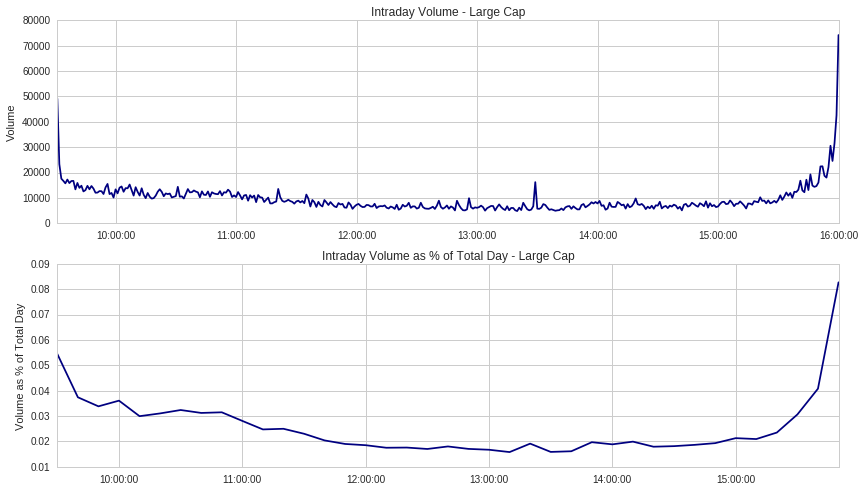

In [9]:
large_cap_avg_volume = large_cap_volume['2016-12-1'].mean(axis=1)

plt.subplot(211)
plt.plot(large_cap_avg_volume.index, large_cap_avg_volume, color='navy')
plt.title("Intraday Volume - Large Cap")
plt.ylabel('Volume')

resampled_large_cap_avg_volume = large_cap_avg_volume.resample('10t', closed='right').sum()

plt.subplot(212)
plt.plot(resampled_large_cap_avg_volume.index, resampled_large_cap_avg_volume/large_cap_avg_volume.sum(), color='navy')
plt.title("Intraday Volume as % of Total Day - Large Cap")
plt.ylabel('Volume as % of Total Day')

Now, we'll average across all days in the month of December 2016 to see how the volume patterns distribute. It seems that there is a much larger proportion of volume towards the end of the day, on one day there is more than 12% of total daily volume in just the last 10 minutes of trading.

One reason why this may occur is because it may be risky to hold positions overnight and traders make a concious effort to close out positions at the end of the day. Doing it the next morning can be tricky as morning trading is often marred with lots of volatility. There may also be information released after the close that could cause adverse price movements, but since the markets are closed there would be little that could be done to handle the situation.

Another reason may be due to the proliferation of index funds. The value of index funds are determined by the day's closing price, and so to minimize tracking error, portfolio managers of index funds will aim to trade as close to the closing price as possible.

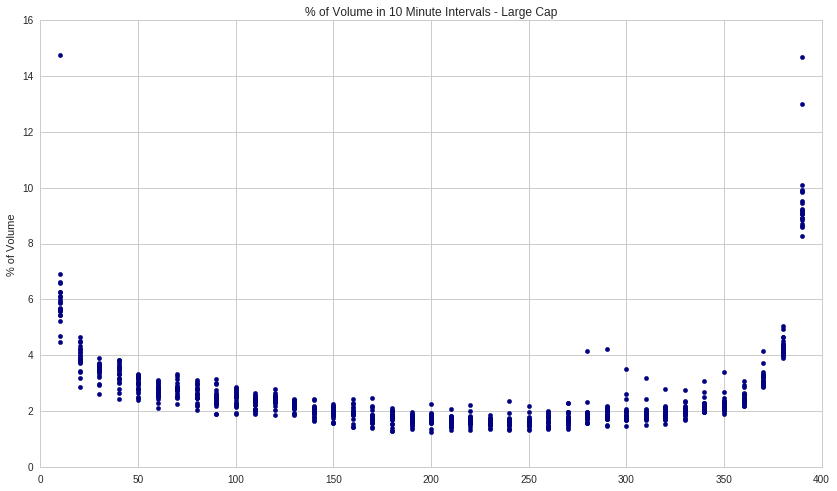

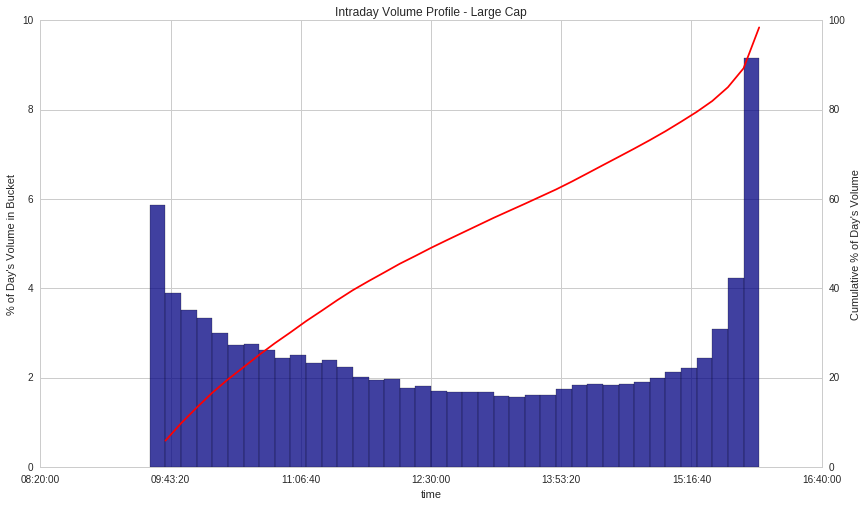

In [52]:
large_volume = intraday_volume_profile_data(large_cap_volume)

plt.scatter(large_volume.minute_of_day, large_volume.interval_pct*100, color='navy')
plt.title('% of Volume in 10 Minute Intervals - Large Cap')
plt.xlim(0, 400)
plt.ylabel('% of Volume')

intraday_profile(large_volume, 'Intraday Volume Profile - Large Cap', '% of Day\'s Volume in Bucket', 'Cumulative % of Day\'s Volume')

### Volume - Small Cap

In [12]:
small_cap_volume.head()

,Equity(21 [AAME]),Equity(106 [ACU]),Equity(112 [ACY]),Equity(117 [AEY]),Equity(225 [AHPI]),Equity(392 [AMS]),Equity(535 [ARTW]),Equity(680 [AXR]),Equity(925 [BKSC]),Equity(1031 [BONT]),...,Equity(50188 [GEMP]),Equity(50237 [SNDE]),Equity(50285 [AZRX]),Equity(50327 [TYHT]),Equity(50349 [AMMA]),Equity(50360 [MRAM]),Equity(50369 [BCTF]),Equity(50374 [OTTW]),Equity(50456 [DFFN]),Equity(50476 [GNUS])
2016-12-01 09:31:00-05:00,1004.0,400.0,0.0,0.0,1250.5,0.0,0.0,0.0,300.0,1208.0,...,0.0,0.0,250.0,0.0,0.0,540.0,0.0,138.0,0.0,0.0
2016-12-01 09:32:00-05:00,0.0,0.0,0.0,0.0,0.0,611.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-01 09:33:00-05:00,0.0,0.0,0.0,155.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-01 09:34:00-05:00,0.0,0.0,0.0,0.0,0.0,106.0,0.0,0.0,135.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-01 09:35:00-05:00,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,900.0


Similar to large cap stocks, we see an uptick in volume at the open and close. However, this occurs on drastically different scales. Not only do small cap stocks trade a lower frequencies and volumes, they also follow a different pattern.

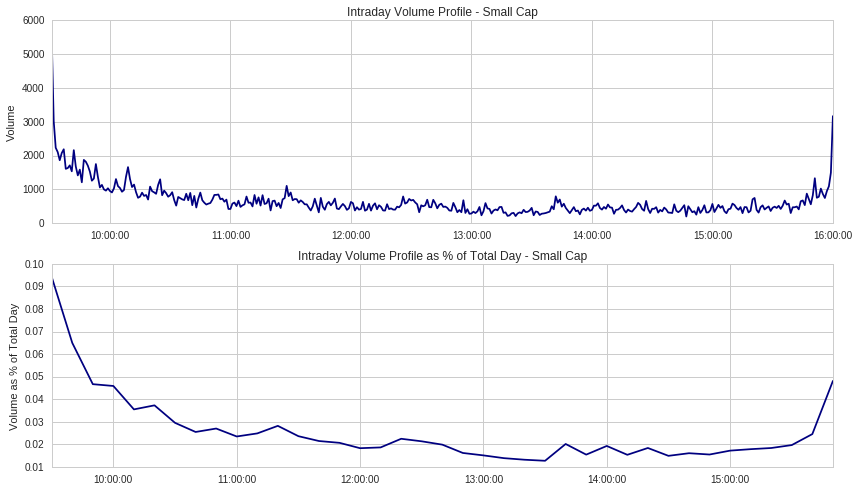

In [13]:
small_cap_avg_volume = small_cap_volume['2016-12-1'].mean(axis=1)

plt.subplot(211)
plt.plot(small_cap_avg_volume.index, small_cap_avg_volume, color='navy')
plt.title("Intraday Volume Profile - Small Cap")
plt.ylabel("Volume")

resampled_small_cap_avg_volume = small_cap_avg_volume.resample('10t', closed='right').sum()

plt.subplot(212)
plt.plot(resampled_small_cap_avg_volume.index, resampled_small_cap_avg_volume/small_cap_avg_volume.sum(), color='navy')
plt.title("Intraday Volume Profile as % of Total Day - Small Cap")
plt.ylabel('Volume as % of Total Day')

As the graphs below show, small cap stocks trade a very large portion of their daily volume at the beginnig of their day. Often going above 10% in just the first 10 minutes. This is the exact opposite pattern we saw with our large cap stocks. A reason why small cap stocks may not follow the same pattern is because they are rarely included in index fund portfolios. This causes them to be of no interest to one of the largest sources of volume.

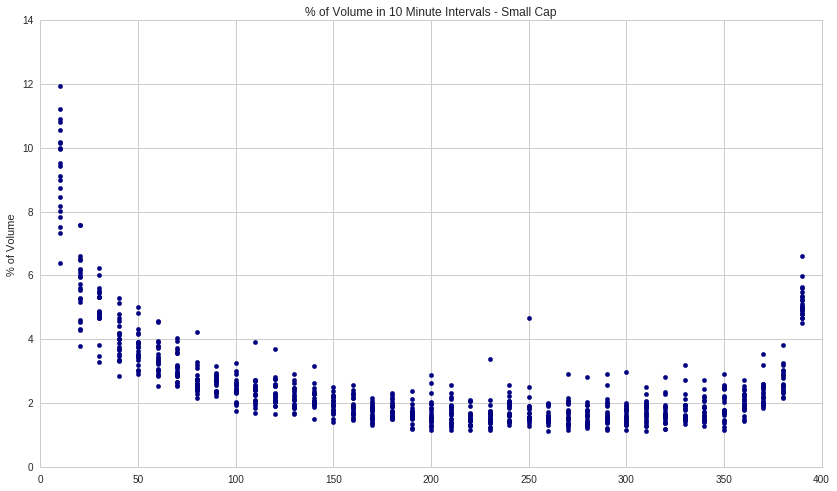

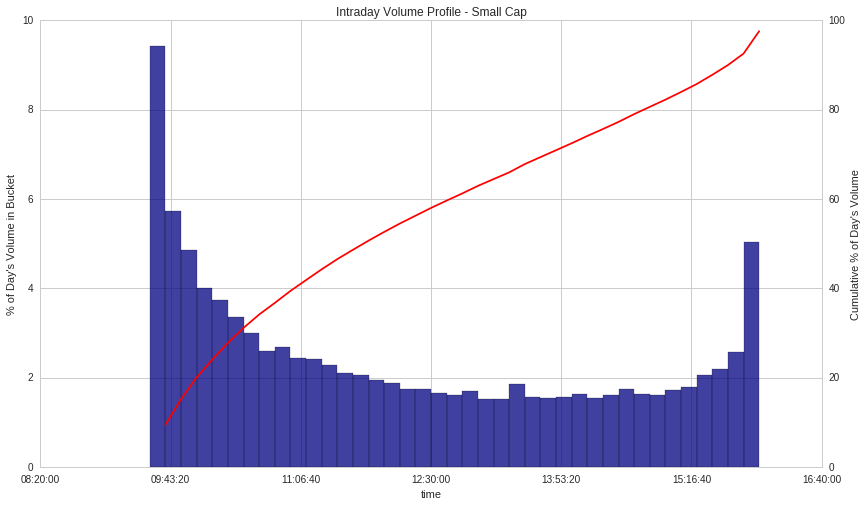

In [46]:
small_volume = intraday_volume_profile_data(small_cap_volume)

plt.scatter(small_volume.minute_of_day, small_volume.interval_pct*100, color='navy')
plt.title('% of Volume in 10 Minute Intervals - Small Cap')
plt.xlim(0, 400)
plt.ylabel('% of Volume')

intraday_profile(small_volume, 'Intraday Volume Profile - Small Cap', '% of Day\'s Volume in Bucket', 'Cumulative % of Day\'s Volume')


Below is the % of volume in each bar for large vs small cap stocks. It's clear that a large part of the daily volume for small cap stocks come out during the morning, whereas a lot of the trading for larger cap stocks occurs right before the close.

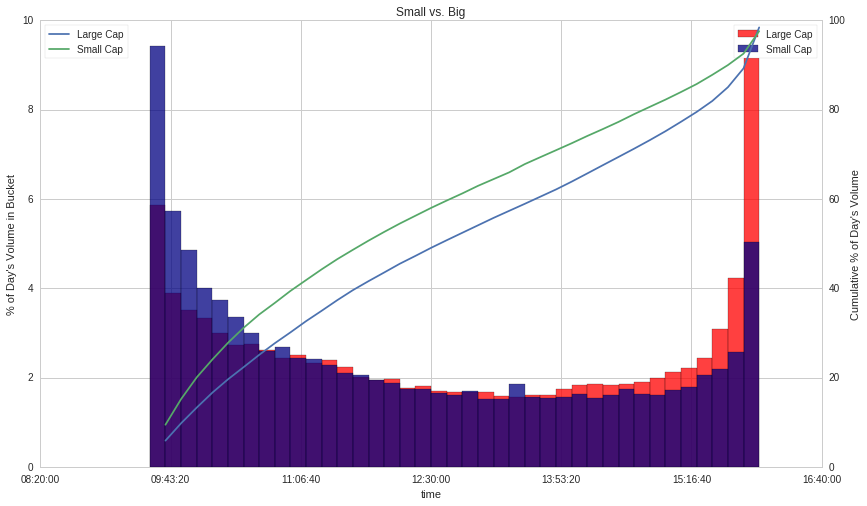

In [15]:
intraday_groups(large_volume, small_volume, '% of Day\'s Volume in Bucket', 'Cumulative % of Day\'s Volume')

The following graph is to give an idea of the true difference in magnitude of volume in small and large cap stocks. Quantitative strategies often find price discrepencies or miscalculations of fair value as sources of alpha. These are plentiful in thinly traded stocks. However if there isn't enough volume to complete the trades then the investment ideas have no value. Further, stocks that don't trade very often are culprits for very bad slippage. It's important to understand why volume constraints can eat away all of your returns and even put you in the red.

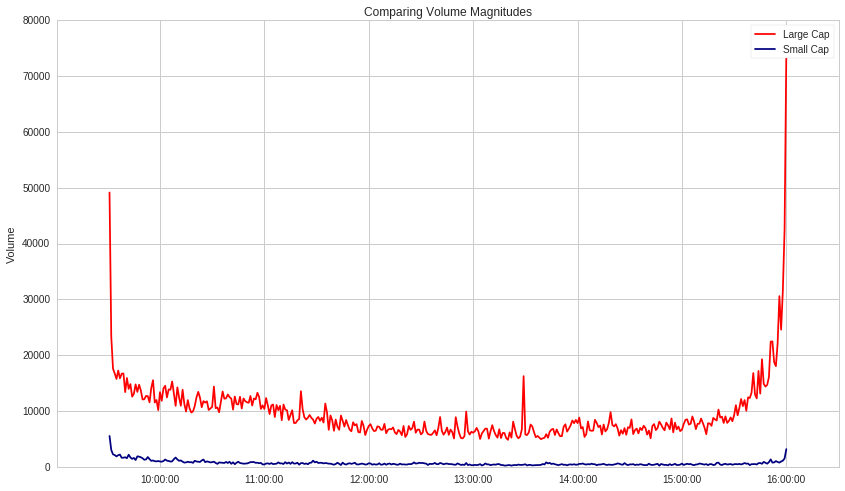

In [16]:
plt.plot(large_cap_avg_volume.index, (large_cap_avg_volume), color='r')
plt.plot(small_cap_avg_volume.index, (small_cap_avg_volume), color='navy')
plt.legend(['Large Cap', 'Small Cap'])
plt.ylabel('Volume')
plt.xlim(large_cap_avg_volume.index[0] - pd.Timedelta(30, unit='m'), \
         large_cap_avg_volume.index[-1] + pd.Timedelta(30, unit='m'))
plt.title('Comparing Volume Magnitudes')


### Volume - Q500 vs. Others

Doing a similar analysis on Q500 stocks vs stocks in neither the Q500 or Q1500, we surprisingly find similar intraday profiles. Although the magnitudes of volume are drastically different, the distribution throughout the day seem very similar. This points to an important issue when trading outside of the Q universes. A strategy that seems sound in research can fail to launch if there isn't enough volume to support it. Our models are based on the idea that you would be able to trade when you'd like and you would be able to complete your whole order at one price. However, this is rarely the case. Trading within the Q universes though ensures that there is always plenty of volume.

In [17]:
all_Q500_data = get_pricing(Q500_assets, frequency='minute',start_date='2016-12-1', end_date='2016-12-31')
Q500_volume = all_Q500_data['volume']
Q500_volume = Q500_volume.tz_convert('US/Eastern') # Q data comes in as UTC

all_other_data = get_pricing(np.random.choice(other_assets, size=500), frequency='minute',start_date='2016-12-1', end_date='2016-12-31')
other_volume = all_other_data['volume']
other_volume = other_volume.tz_convert('US/Eastern') # Q data comes in as UTC

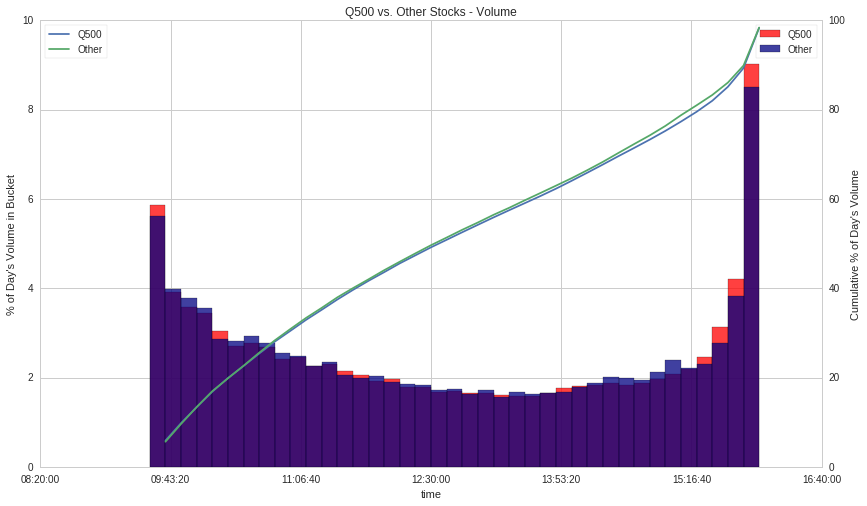

In [18]:
Q500_volume_data = intraday_volume_profile_data(Q500_volume)
other_volume_data = intraday_volume_profile_data(other_volume)

intraday_groups(Q500_volume_data, other_volume_data, '% of Day\'s Volume in Bucket', 'Cumulative % of Day\'s Volume', 'Q500 vs. Other Stocks - Volume', 'Q500', 'Other')

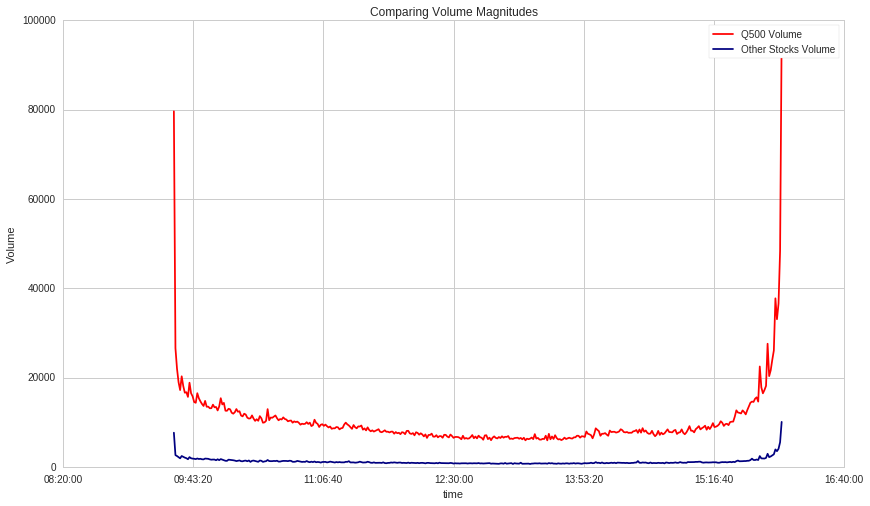

In [19]:
Q500_volume_timeOfDay = Q500_volume.groupby(Q500_volume.index.time).mean()
plt.plot((Q500_volume_timeOfDay.mean(axis=1)), color='r')

other_volume_timeOfDay = other_volume.groupby(other_volume.index.time).mean()
plt.plot((other_volume_timeOfDay.mean(axis=1)), color='navy')

plt.legend(['Q500 Volume', 'Other Stocks Volume'])
plt.ylabel('Volume')
plt.title('Comparing Volume Magnitudes')

In [28]:
del Q500_volume, other_volume, Q500_volume_data, other_volume_data, Q500_volume_timeOfDay, other_volume_timeOfDay


### Volatility

As there is no measure of volatility available, we will have to calculate our own intraday metric. The standard measure for volatility is to use percentage changes in close-to-close prices. However, this won't help us in understanding intraday trading patterns and would not be using the rich OHLC data we have access to. Instead, we will use the Garman and Klass estimate of realized variance as explained in this paper by [Almgren (2009)](http://cims.nyu.edu/~almgren/timeseries/notes7.pdf).

$$\sigma^2 = RV_{GK} = \sum^N_{i=1} \left(\frac{1}{2}\left(H_i - L_i \right)^2   - (2 \log 2 -1) \left( C_i - C_{i-1} \right)^2 \right)$$

We will measure volatility over 10 minute bars, with $N = 10$; $H_i =$ high of the asset in the $i_{th}$ minute; $L = \text{the low}$; and $C = \text{the close}$.

In [22]:
def GK_sum(open_price, high, low, close_price, close_tm1):
    return 0.5*((high - low)**2) - ((np.log10(4)-1)*((close_price-close_tm1)**2))
    
def GK_var(df):
    df['variance'] = GK_sum(df.open_price, df.high, df.low, df.close_price, df.close_price.shift(1))
    
    return pd.DataFrame({'variance': df['variance'].groupby(pd.TimeGrouper('10t', level=1)).sum()})

def intraday_volatility_profile_data(ohlc_data):
    
    # calculate variance on a per stock basis
    groups = ohlc_data.groupby(level=0).apply(GK_var)
    
    # take the mean of all variances
    ten_minute_variance = pd.DataFrame({'variance': groups.groupby(level=1)['variance'].mean()})
    ten_minute_variance['minute_of_day'] = (ten_minute_variance.index.hour - 9) * 60 + (ten_minute_variance.index.minute - 30)
    ten_minute_variance['time'] = ten_minute_variance.index.time

    # calculate daily variance
    dailySum = pd.DataFrame(ten_minute_variance['variance'].resample('d').sum())
    dailySum.columns = ['daily_variance']
    dailySum['day'] = dailySum.index.date

    # calculate interval variance
    conversion = {'variance' : 'sum', 'minute_of_day' : 'last', 'time':'last'}
    interval_data = ten_minute_variance.resample('10t', closed='right').apply(conversion)
    interval_data['day'] = interval_data.index.date
    interval_data['time'] = interval_data.index.time

    # put them together
    intraday_data = interval_data.merge(dailySum, how='left', on='day')
    intraday_data['interval_pct'] = intraday_data['variance'] / intraday_data['daily_variance']
    
    return intraday_data

### Volatility - Large Cap

Let's look at some data now.

In [23]:
large_cap_data = all_large_cap_data

large_cap_data.major_axis = large_cap_data.major_axis.tz_convert('US/Eastern')
large_cap_data = large_cap_data.transpose(0, 2, 1).to_frame()
large_cap_data.index.names = ["assets", "date"]

large_cap_data.dropna(inplace=True)

large_cap_volatility = intraday_volatility_profile_data(large_cap_data)

As expected, the first 10 minutes of trading has an incredibly high rate of volatility. Not only is the % of volatility at the open noteworthy, but it's also interesting to see the dispersion of values in the first day minutes across different days. Some days the first bar contains less than 10% of daily volatiliy, on other days however it contains almost 60%. This demonstrates the process of price discovery. Price discovery is how the price of assets are determined in the market place and differs from valuations. The price of an asset is formed through the interactions of buyers and sellers. When we see high volatility in the beginning of the day, this is often a sign of market participants trying to determine the "fair market price" given the information that has come out since the market close the day before. On some days this information is especially material and can cause some huge fluctuations, often a sign of wide spreads. If you take one thing away from this lecture it is that you should not trade in the first 30 minutes of the day, spreads are unreasonably wide and are almost guaranteed to converge once the market settles.

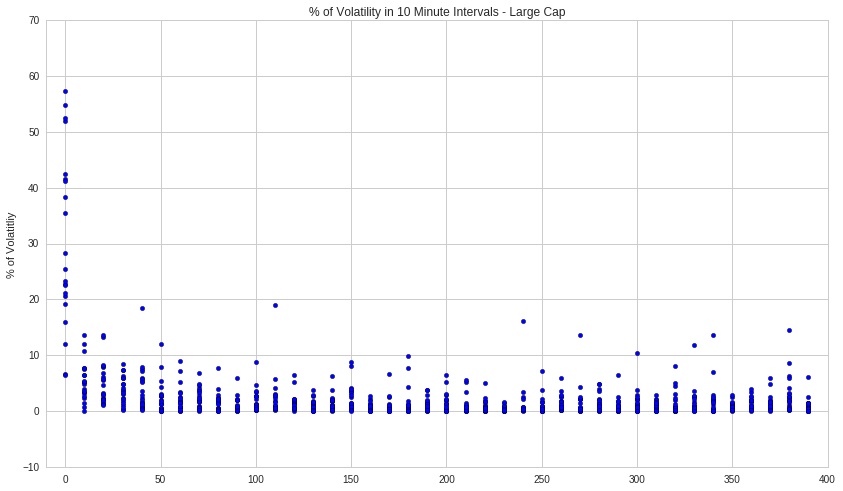

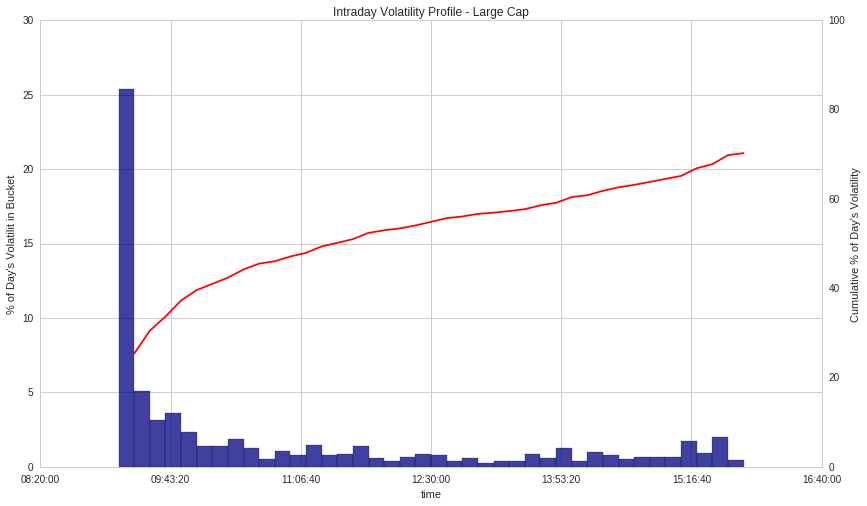

In [54]:
# what does the plot of this look like?
plt.scatter(large_cap_volatility['minute_of_day'], large_cap_volatility['interval_pct']*100)
plt.title('% of Volatility in 10 Minute Intervals - Large Cap')
plt.ylabel('% of Volatitliy')
plt.xlim(-10, 400)

intraday_profile(large_cap_volatility, 'Intraday Volatility Profile - Large Cap', '% of Day\'s Volatilit in Bucket', 'Cumulative % of Day\'s Volatility')

### Volatility - Small Cap

Looking at small cap companies, it seems that there is a much larger rate of volatility at play. One of the risks of investing in small cap stocks, apart from the risk of volume shortages, is that there is little information about them. This can mean that is it often difficult to discern the "fair market value" of a stock and that price discovery is especially painful. Small cap stocks also experience high rates of volatility as even small trades can become a large percentage of ADV, causing large price movements.

In [30]:
small_cap_data = all_small_cap_data

small_cap_data.major_axis = small_cap_data.major_axis.tz_convert('US/Eastern')
small_cap_data = small_cap_data.transpose(0, 2, 1).to_frame()
small_cap_data.index.names = ["assets", "date"]

small_cap_data.dropna(inplace=True)

small_cap_volatility = intraday_volatility_profile_data(small_cap_data)

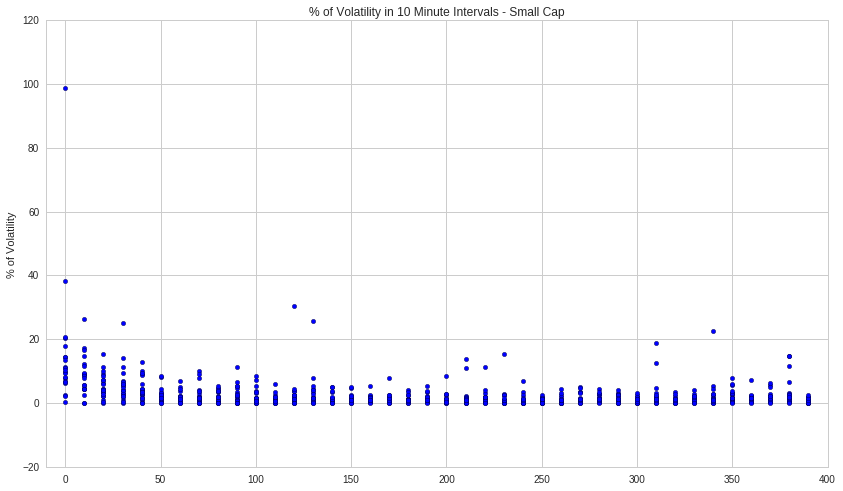

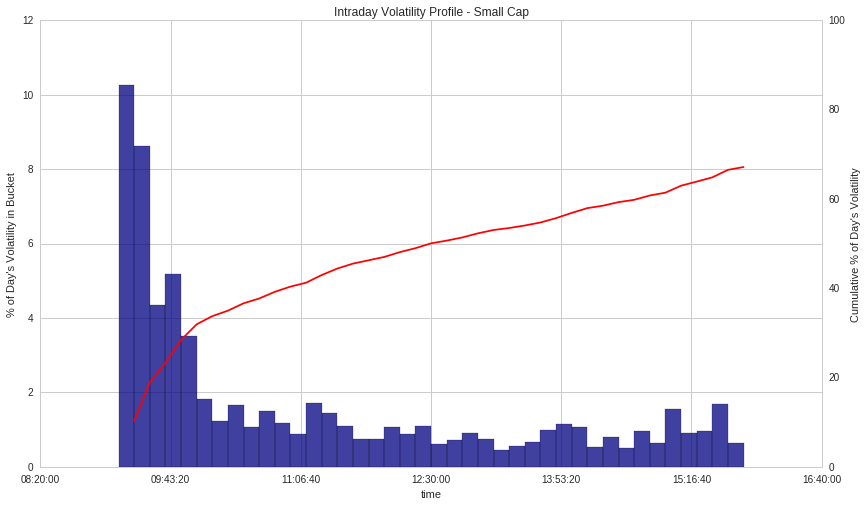

In [51]:
# what does the plot of this look like?
plt.scatter(small_cap_volatility['minute_of_day'], small_cap_volatility['interval_pct']*100)
plt.title('% of Volatility in 10 Minute Intervals - Small Cap')
plt.xlim(-10, 400)
plt.ylabel('% of Volatility')

intraday_profile(small_cap_volatility, 'Intraday Volatility Profile - Small Cap', '% of Day\'s Volatility in Bucket', 'Cumulative % of Day\'s Volatility')


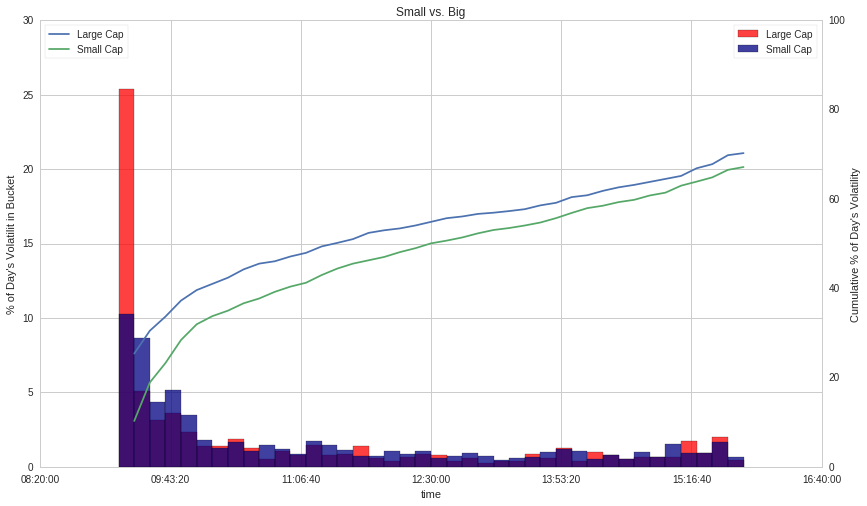

In [34]:
intraday_groups(large_cap_volatility, small_cap_volatility, '% of Day\'s Volatilit in Bucket', 'Cumulative % of Day\'s Volatility')

# Transaction Cost Analysis

### What are Transaction Costs?

Transaction costs are what you would have to pay to execute your investment ideas above and beyond the fair market costs associated the actual securities themselves. This means the difference between the price of the stock you want to buy and the final cost of actually obtaining that stock. Transaction costs are generally separated into two categories: direct and indirect.

Direct transaction costs refer to the fees that you would pay to actual individuals and counterparties, and they are usually known beforehand. These can include commission to broker-dealers for execution services, taxes on investment income, and rebates (see [Maker-Taker Model](http://lexicon.ft.com/Term?term=make_or_take-pricing)). 

Indirect transaction costs refer to costs that are not known prior to trading and depend highly on the execution strategies used. Two of the biggest components of indirect transaction costs are market impact and opportunity costs. The latter refers to the profits forgone by not being able to enter into a position or the losses incurred by not being to exit a position in time. This can occur when there isn't enough counterparty liquidity to complete your trades or because of untimely price movements. Market impact, which we will be focusing on, is the change in the price of a stock caused by an order to buy or sell it. 


### What is Transaction Cost Analysis?

In the institutional setting we're in, we can ignore direct costs as they are trivial compared to the larger effects of market impact. It is immensely important that transaction costs are taken into consideration when devising investment strategies as they are one of the most common reasons why ideas borne in research can fail to pan out in actual markets. Transaction cost analysis (TCA) is helpful in understanding the pitfalls of strategies and is vital in achieving best execution. Although standard measures of best execution rely on comparisons to various benchmarks, such as the VWAP price, it is more about an investor's capability to consider market uncertainties when making trading decisions. In particular, the proliferation of algorithmic trading has advanced TCA to the point where it can be used pre-trade, intraday, and post-trade.

Pre-trade TCA, which is the most relevant to us, deals with predicting the market impact of our trades. Specifically, TCA is being integrated into the stock selection phase of the investment cycle through quantitative overlays, market impact scores, cost curves, portfolio optimization, and backtesting. Intraday TCA involves the supervision of execution strategies to ensure they fall within the performance standards that we have set and are behaving appropriately to changing market conditions. Finally, TCA is used post-trade to measure actual performance. The cycle of transaction cost analysis is on-going and vital to the research driven investment proces. 

## Market Impact

Mathematically, market impact is defined as the "... difference between actual price trajectory after the order is released to the market and the price trajectory that would have occured if the order were never released." (__CITATION TO KISSELL TEXTBOOK???__) Market impact is broken into two components, permanent and temporary. Permanent MI occurs due to the information content you release into the market as you signal your willingness to trade. This causes market participants to alter their perception of fair value for an asset. This is the unavoidable cost of trading. Temporary MI, however, can be managed and minimized using optimal execution strategies, since it is the price change caused by your demand for liquidity. This is highly dependent on your urgency to complete an order (and of course, many other factors), but can losely be thought of as the premium you need to pay to attract counterparties to complete your trade. 

Market impact models attempt to replicate the effects that a trade would have on the greater market. Empirically, it is shown that market impact increases with the size of the trade, the volatility of the stock, and the urgency with which you would like to complete your trade.

### Market Impact Model

We will be implementing a model of market impact based on the following paper by Almgren et al. (2005): [Direct Estimation of
Equity Market Impact](http://www.cims.nyu.edu/~almgren/papers/costestim.pdf)

The paper presents a model that breaks market impact into its two components and attempts to classify the dependence of market impact on order size and trade time. For permanent impact, it is important to have some measure of liquidity which depends on the market parameters that define each individual stock, aside from volume an volatility. Possible candidates for this are shares outstanding, bid-ask spreads, and market capitalization. The authors found shares outstanding, in particular the inverse of "turnover" which is the fraction of a company's total value traded each day, to be the most robust metric to use, compared to bid-ask spreads and market capitalization which was found to have no significant effect. Temporary impact was found to have no such need for stock specific modifications above volume and volatility.

Using a modified Gauss-Newtonian optimization algorithm, parameters are found to fit the measures of permanent and temporary impact. Namely, the liquidity factor, $\delta$, is $1/4$, and temporary impact, $\beta$, is defined as a concave function at $3/5$. Empirically, this makes sense. As investors want to trade a larger amount, the less additional trade costs they will incur per share, as we will see. 
The model is described below:

$$\text{Market Impact} = \text{Permanent Impact} + \text{Temporary Impact}$$

$$\text{MI} = \frac{1}{2} \: \overbrace{\gamma \: \sigma \left(\frac{x}{v}\right) \left(\frac{\theta}{v}\right)^{\delta}}^{\text{permanent}} + \overbrace{\eta \: \sigma \: \left| \frac{x}{vt} \right|^{\beta}}^{\text{temporary}} $$

$$x = \text{unsigned number of shares to trade}$$

$$v = \text{average daily volumme (ADV)}$$

$$t = \text{time width in % of trading time}$$

$$\sigma = \text{daily volatility}$$

$$\theta = \text{shares outstanding}$$

$$\delta = 1/4$$

$$\beta = 3/5$$

where $\gamma$ and $\eta$ are the "universal coefficients of market impact" and estimated by the authors using a large sample of institutional trades. The interpretation of $\frac{\Theta}{v}$ is the inverse of daily turnover. Finally, as a simplifying measure it is assumed that the order is completed by a uniform rate of trading over the time interval.


### Potential Limitations

Note that this paper was released prior to the adoption and phased implementation of [__Reg NMS__](https://www.sec.gov/rules/final/34-51808.pdf), prior to the "quant meltdown" of August 2007, prior to the financial crisis hitting markets in Q4 2008, and other numerous developments in market microstructure. Nevertheless, this model can provide numerous insights and act as a pivotal first step. More advanced models consider other factors such as the bid-ask spread and book depth, however the model is fit on actual execution data and the realized cost is measured against the mid price. So the act of paying the bid-ask spread over child executions of the parent order is already embedded in the data and the parameters reflect this.

In [76]:
# the break-up of the permanent and temporary impacts
# they are multiplied by 10000 since we want the cost in bps
def perm_impact(pct_adv, daily_vol_pct=0.25, inv_turnover=200):
    gamma = 0.314
    return 10000 * gamma * daily_vol_pct * pct_adv * (inv_turnover)**0.25

def temp_impact(pct_adv, minutes, daily_vol_pct=0.25, minutes_in_day=60*6.5):
    eta = 0.142
    day_frac = minutes / minutes_in_day
    return 10000 * eta * daily_vol_pct * abs(pct_adv/day_frac)**0.6

def mi_bps(pct_adv, minutes, daily_vol_pct=0.25, inv_turnover=200, minutes_in_day=60*6.5):
    perm = perm_impact(pct_adv, daily_vol_pct, inv_turnover)
    temp = temp_impact(pct_adv, minutes, daily_vol_pct, minutes_in_day)
    return 0.5 * perm + temp


Replicated from the paper, we see how the permanent and temporary impacts of trading stock "A" changes as we allow the trade to complete slower and slower.

  Variable      |      Asset A
  ------------- | -------------
  Inverse turnover ($\Theta/v$) | 263
  Daily vol ($\sigma$)  | 1.57%
  Trade % ADV (X/V) | 10%
  
  Item | Fast | Medium | Slow
  -----|------|--------|-------
  Trade duration (day fraction %) | 10% | 20% | 50%
  Permanent Impact (bps) | 20 | 20 | 20
  Temporary Impact (bps) | 22 | 15 | 8
  Total Impact (bps) | 32 | 25 | 18
  
It is important to note here that this is only replicating market impact! There are other aspects to transaction costs, namely opportunity cost, that aren't captured. As we allow ourselves to trade slower we are lowering our temporary market impact, but we are exposing ourselves more and more to adverse price movements and the risk of liquidity depletion.

We'll now see our code estimates for the same experiment.

In [77]:
print mi_bps(pct_adv=0.1, daily_vol_pct=0.0157, inv_turnover=263, minutes=0.1*60*6.5) 
print mi_bps(pct_adv=0.1, daily_vol_pct=0.0157, inv_turnover=263, minutes=0.2*60*6.5) 
print mi_bps(pct_adv=0.1, daily_vol_pct=0.0157, inv_turnover=263, minutes=0.5*60*6.5) 

32.2203193206
24.634874002
18.4143315025


For all the following examples, we will fixe a rate of inverse turnover and focus more on the relationship between trade size and time time. Now, to motivate some intuition, let's look at the relationship between trade costs and trade size at two levels of volatility, given we want to complete in 30 minutes.

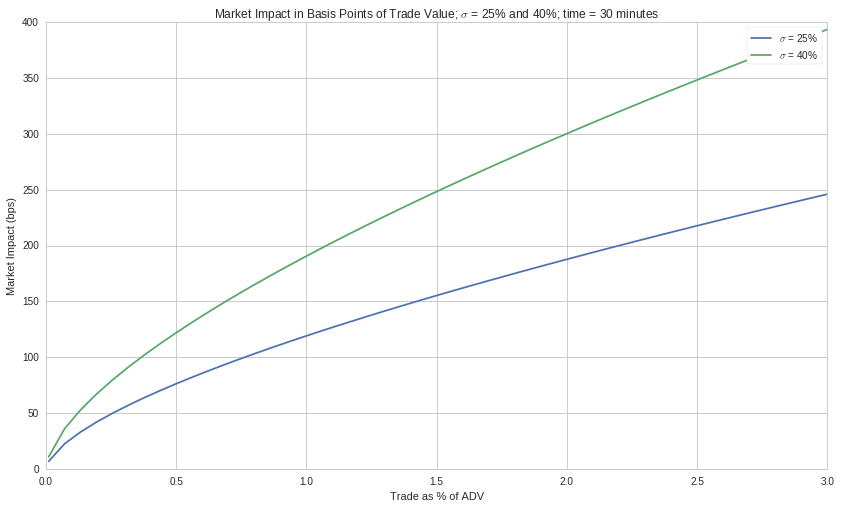

In [78]:
x = np.linspace(0.0001,0.03)
plt.plot(x*100,mi_bps(x,30,0.25), label="$\sigma$ = 25%");
plt.plot(x*100,mi_bps(x,30,0.40), label="$\sigma$ = 40%");
plt.ylabel('Market Impact (bps)')
plt.xlabel('Trade as % of ADV')
plt.title('Market Impact in Basis Points of Trade Value; $\sigma$ = 25% and 40%; time = 30 minutes');
plt.legend();

Let's look at market impact as it pertains to different combinations of trade size and trade time. The curves below all demonstrate the tradeoff between trade time and trade size. Given a level of market impact, to achieve a higher level of volume would mean having to wait longer to be completed, and thus face the associated risks. It also seems that as you become a larger and larger portion of the average daily volume, the tradeoff becomes less material. As we saw with the graph above, the difference in market impact between two levels of volatility appears to be notable. With the same percentage of ADV and trade time, you would achieve drastically higher rates of market impact. With a trade time of 20 minutes and trade size at 1.5% of ADV, you would have a market impact of approximately 157 bps with 20% volatility, but almost 315 bps with 40% volatility. 

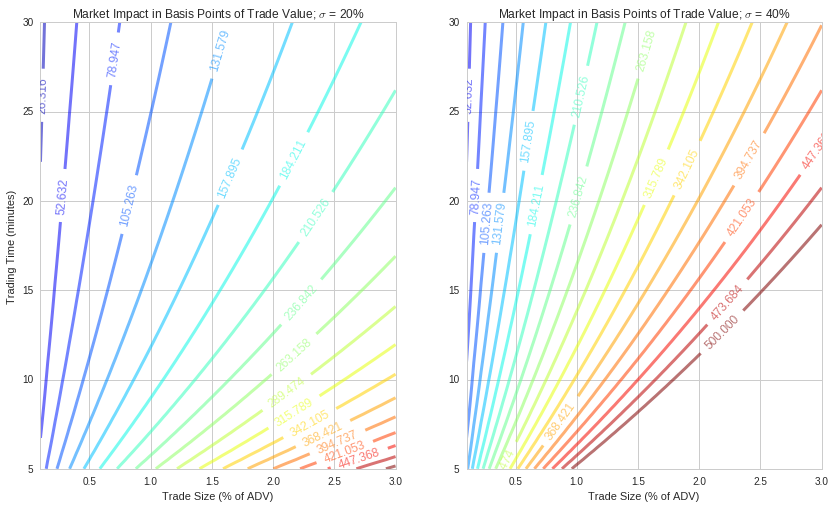

In [79]:
x = np.linspace(0.001,0.03) # % of ADV
y = np.linspace(5,30) # trade time in minutes
X, Y = np.meshgrid(x,y)
Z = mi_bps(X, Y, 0.20) # 20% is daily vol pct
levels = np.linspace(0.0, 500, 20)
cmap=plt.get_cmap('jet')


plt.subplot(121)
CS = plt.contour(X * 100, Y, Z, levels, linewidths=3, cmap=cmap, alpha=0.55)
plt.clabel(CS)
plt.ylabel('Trading Time (minutes)')
plt.xlabel('Trade Size (% of ADV)')
plt.title('Market Impact in Basis Points of Trade Value; $\sigma$ = 20%')

plt.subplot(122)
Z = mi_bps(X , Y, 0.40)
CS = plt.contour(X * 100, Y, Z, levels, linewidths=3,cmap=cmap, alpha=0.55)
plt.clabel(CS)
plt.xlabel('Trade Size (% of ADV)')
plt.title('Market Impact in Basis Points of Trade Value; $\sigma$ = 40%')

Alternatively, we might want to get some intuition as to if we wanted to limit our cost, how does the trading time vary versus percentage of ADV. On one end of the spectrum, you'll see that wanting to keep your market impact at a minimum while executing a large portion of shares means being very patient (it would take almost the entire day to complete)! As well, we can see that keeping % ADV and MI the same, we would have to accept much longer trade times on comparable stocks with greater volatility. 

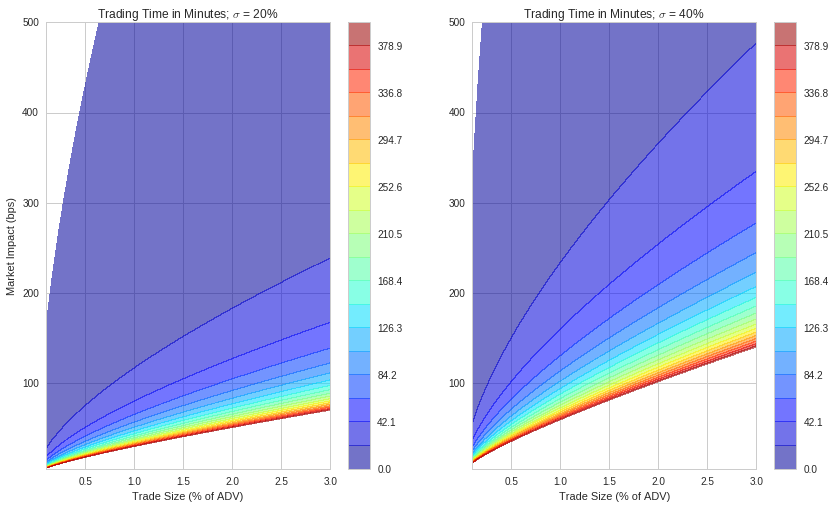

In [80]:
x = np.linspace(0.001, 0.03) # % ADV
y = np.linspace(1, 60 * 6.5)   # time to trade
X, Y = np.meshgrid(x,y)

levels = np.linspace(0.0, 400, 20)
cmap=plt.get_cmap('jet')

plt.subplot(121)

Z = mi_bps(X, Y, 0.20)
plt.contourf(X * 100, Z, Y, levels, cmap=cmap, alpha=0.55)
plt.title('Trading Time in Minutes; $\sigma$ = 20%')
plt.xlabel('Trade Size (% of ADV)')
plt.ylabel('Market Impact (bps)')
plt.ylim(5, 500)
plt.colorbar()

plt.subplot(122)
Z = mi_bps(X, Y, 0.40)
plt.contourf(X * 100, Z, Y, levels, cmap=cmap, alpha=0.55)
plt.title('Trading Time in Minutes; $\sigma$ = 40%')
plt.xlabel('Trade Size (% of ADV)')
plt.ylim(5, 500)
plt.colorbar()

### The Breakdown: Permanent and Temporary

For a typical stock, let's see how market impact is broken down into permanent and temporary.

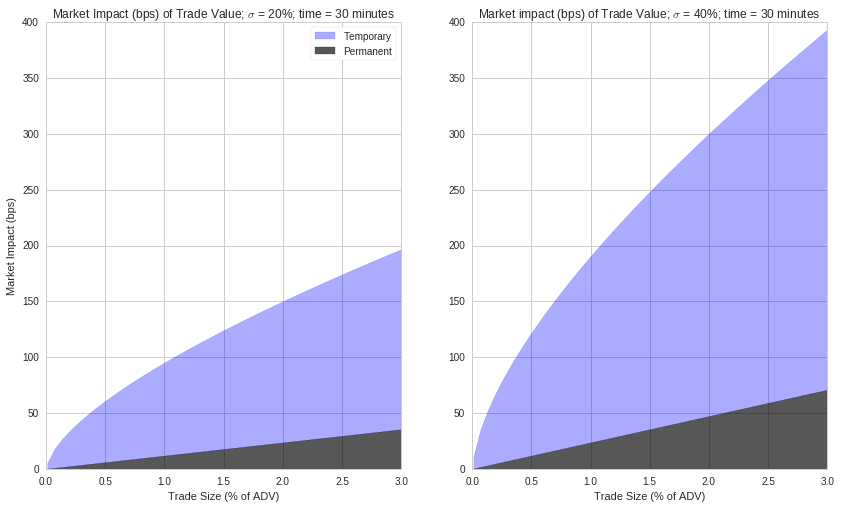

In [81]:
minutes = 30 # we want to complete our orders in 30 minutes

x = np.linspace(0.0001,0.03) # % of ADV

f, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=False)
f.subplots_adjust(hspace=0.15)
    
p = 0.5*perm_impact(x, 0.20)
t = mi_bps(x, minutes, 0.20)

ax1.fill_between(x * 100, p, t, color='b',alpha=0.33)
ax1.fill_between(x * 100, 0, p, color='k',alpha=0.66)

ax1.set_ylabel('Market Impact (bps)')
ax1.set_xlabel('Trade Size (% of ADV)')
ax1.set_title('Market Impact (bps) of Trade Value; $\sigma$ = 20%; time = 30 minutes')
ax1.set_ylim(0, 400)
ax1.legend(['Temporary', 'Permanent'])

p = 0.5*perm_impact(x, 0.40)
t = mi_bps(x, minutes, 0.40)

ax2.fill_between(x * 100, p, t, color='b',alpha=0.33)
ax2.fill_between(x * 100, 0, p, color='k',alpha=0.66)

ax2.set_xlabel('Trade Size (% of ADV)')
ax2.set_title('Market impact (bps) of Trade Value; $\sigma$ = 40%; time = 30 minutes')

### Ranking the Q Universes

Now, let's look at price impact with actual stocks, comparing across those in Q universes and those not.

Taking our pipeline results from the beginning of the lecture, we'll calculate for each asset ADV, annualized volatility, and daily volatility.

In [82]:
T = len(pipeline_results.index.levels[0])

metrics = pd.DataFrame({'ADV': pipeline_results.volume.mean(level=1),
                       'Annualized Volatility': (pipeline_results.returns.std(level=1)*(250/(T-1)))**0.5,
                       'Daily Volatility': (pipeline_results.returns.std(level=1)*(T-1))**0.5,
                       'Market Cap': pipeline_results.market_cap.mean(level=1),
                       'Shares Outstanding': pipeline_results.shares_outstanding.mean(level=1),
                       'Annual Returns': pipeline_results.returns.mean(level=1),
                       'Q1500': pipeline_results.groupby(level=1)['Q1500'].any(),
                       'Q500': pipeline_results.groupby(level=1)['Q500'].any()}).dropna()

metrics.head()


,ADV,Annual Returns,Annualized Volatility,Daily Volatility,Market Cap,Q1500,Q500,Shares Outstanding
Equity(21 [AAME]),3.683864e+03,0.004910,0.680815,0.940682,7.907041e+07,False,False,2.042340e+07
Equity(24 [AAPL]),2.218087e+07,0.001781,0.289910,0.400568,6.075929e+11,True,True,5.332310e+09
Equity(31 [ABAX]),1.165872e+05,0.000548,0.388104,0.536243,1.185146e+09,False,False,2.253473e+07
Equity(39 [DDC]),3.021574e+05,0.001299,0.463680,0.640666,8.251480e+08,False,False,8.781810e+07
Equity(41 [ARCB]),2.472507e+05,-0.003812,0.459722,0.635197,7.760125e+08,False,False,2.563985e+07


Note: $\sigma_{annual} = \sqrt{\frac{250}{T - 1}\sum^{T}_{i = 2}(r_i - r_{avg})^2}$ and $\sigma_{daily} = \sqrt{\frac{1}{T - 1}\sum^{T}_{i = 2}(r_i - r_{avg})^2}$

Assume we would like to trade 10% of the average daily volume and complete our orders within 30 minutes. What would our average market impact be across stocks in the Q500, Q1500, and stocks in neither of those universes?

Looking at the box plots below, we cannot discern any difference between market impact in the Q500 and Q1500 universes, however it clear that trading outside of both universes is likely to have a material impact on returns. 

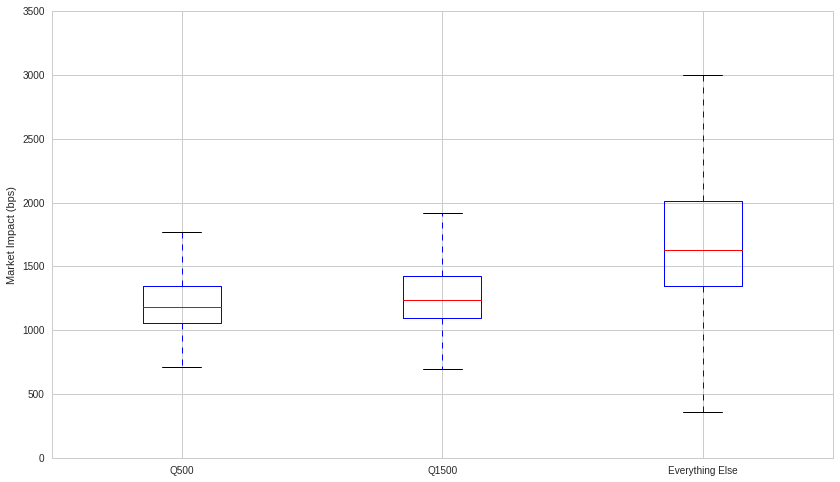

In [83]:
metrics['MI'] = mi_bps(0.1, 30, metrics['Daily Volatility'], metrics['Shares Outstanding']/metrics['ADV'])

Q500_metrics = metrics[(metrics['Q500'])]
Q1500_metrics = metrics[(metrics['Q1500'])]
other = metrics[(~metrics['Q500']) & (~metrics['Q1500'])]

plt.boxplot([Q500_metrics['MI'], Q1500_metrics['MI'], other['MI']], showfliers=False)
plt.xticks([1, 2, 3], ['Q500', 'Q1500', 'Everything Else'])
plt.ylabel('Market Impact (bps)')


We can quickly test for statistically significant differences between the groupings using the Kolmogorov-Smirnov statistic. We will test all the groups against each other, with our null hypothesis being that they are drawn from the same distribution.

In [84]:
d1, p_value1 = stats.ks_2samp(Q500_metrics['MI'], Q1500_metrics['MI'])
print 'p-value for difference between market impact of Q500 and Q1500 stocks:', p_value1

d2, p_value2 = stats.ks_2samp(Q1500_metrics['MI'], other['MI']) 
print 'p-value for difference between market impact of Q1500 and other stocks: ', p_value2

d3, p_value3 = stats.ks_2samp(Q500_metrics['MI'], other['MI'])
print 'p-value for difference between market impact of Q500 and other stocks: ', p_value3

p-value for difference between market impact of Q500 and Q1500 stocks: 0.000627224351035
p-value for difference between market impact of Q1500 and other stocks:  9.9129022091e-172
p-value for difference between market impact of Q500 and other stocks:  3.29031211248e-99


We will also look at how they vary with respect to annual returns.

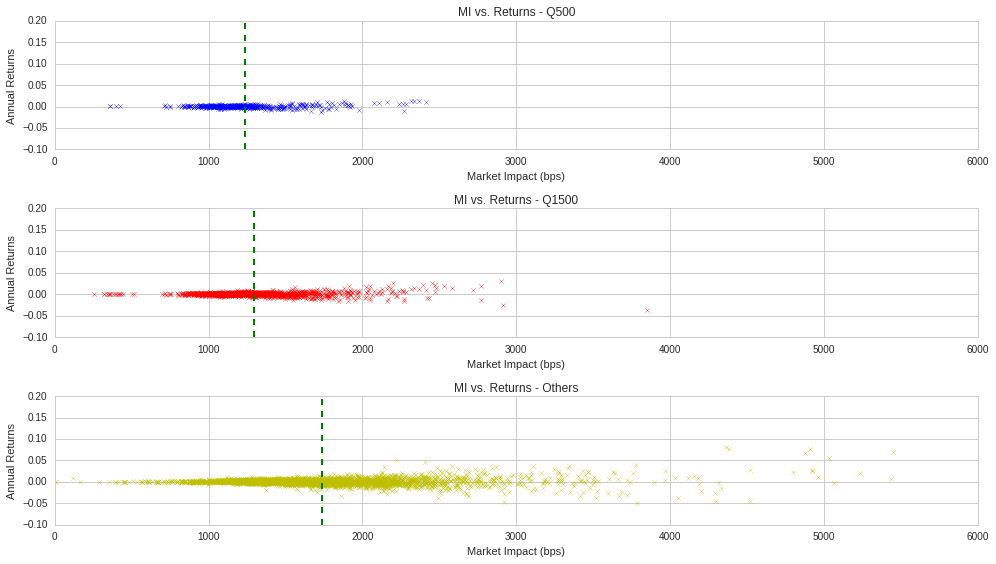

In [85]:
plt.subplot(311)
plt.scatter(Q500_metrics['MI'], Q500_metrics['Annual Returns'], marker="x", color="b")
plt.axvline(Q500_metrics['MI'].mean(), color='g', linestyle='--', lw=2)
plt.title("MI vs. Returns - Q500")
plt.xlabel('Market Impact (bps)')
plt.ylabel('Annual Returns')
plt.xlim(0, 6000)
plt.ylim(-0.1, 0.2)

plt.subplot(312)
plt.scatter(Q1500_metrics['MI'], Q1500_metrics['Annual Returns'], marker="x", color="r")
plt.axvline(Q1500_metrics['MI'].mean(), color='g', linestyle='--', lw=2)
plt.title("MI vs. Returns - Q1500")
plt.xlabel('Market Impact (bps)')
plt.ylabel('Annual Returns')
plt.xlim(0, 6000)
plt.ylim(-0.1, 0.2)

plt.subplot(313)
plt.scatter(other['MI'], other['Annual Returns'], marker="x", color="y")
plt.axvline(other['MI'].mean(), color='g', linestyle='--', lw=2)
plt.title("MI vs. Returns - Others")
plt.xlabel('Market Impact (bps)')
plt.ylabel('Annual Returns')
plt.xlim(0, 6000)
plt.ylim(-0.1, 0.2)

plt.tight_layout()

### For the Optimization Objective Function

Although beyond the scope of this lecture, the goal for pre-trade transaction cost analysis is to utilize it in our portfolio selection process. We want to ensure that the alphas we are trying to capture are not overwhelmed by their transaction costs. Usually, this would involve including a factor of trade cost into our model before the optimization step. This will be discussed in more detail in future lectures.